# 6.5.2 例題: 株売買の収益

In [1]:
using Distributed
addprocs(3)
@everywhere using Mamba

┌ Info: Recompiling stale cache file /Users/apple/.julia/compiled/v1.1/Mamba/y2fzO.ji for Mamba [5424a776-8be3-5c5b-a13f-3551f69ba0e6]
└ @ Base loading.jl:1184


In [22]:
using DataFrames
using Dates
using Distributions
using DotEnv
using HTTP
using JSON
using Plots
using Printf
using LinearAlgebra

In [3]:
export_prior_params = Dict(
    "AAPL" => (0.05, 0.03),
    "GOOG" => (-0.03, 0.04),
    "TSLA" => (-0.02, 0.01),
    "AMZN" => (0.03, 0.02),
)
stocks = collect(keys(export_prior_params))

4-element Array{String,1}:
 "AMZN"
 "GOOG"
 "AAPL"
 "TSLA"

## 事前分布

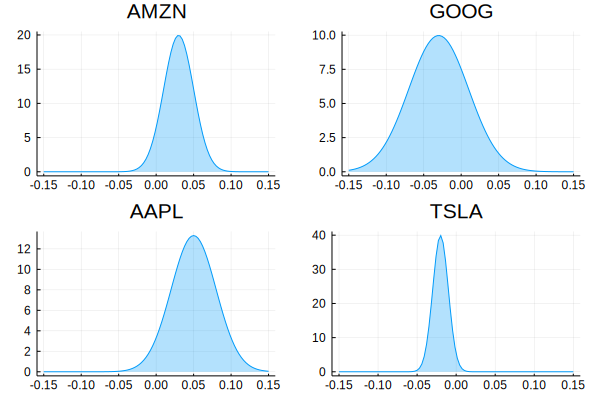

In [16]:
plts = []
x = range(-0.15, stop = 0.15, length = 100)

for (name, (mu, sig)) in export_prior_params
    push!(plts, Plots.plot(x, pdf.(Normal(mu, sig), x), title = name, label = "", fillrange = 0, fillalpha = 0.3))
end

Plots.plot(plts..., layout = (2, 2), size = [600, 400])

In [5]:
DotEnv.config();
api_key = ENV["ALPHAVANTAGE_API_KEY"];

In [119]:
function get_historical_price(ticker)
    timeseries_url = @sprintf(
        "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&apikey=%s",
        ticker,
        api_key)
    r = HTTP.get(timeseries_url)

    ts = JSON.parse(IOBuffer(r.body))["Time Series (Daily)"]
    tsv = collect(values(ts))
    df = DataFrame(permutedims(hcat(collect.(values.(tsv))...), (2, 1)), Symbol.(collect(keys(tsv[1]))))
    names!(df, Symbol.(["close", "volume", "high", "open", "low"]))
    df[:date] = Date.(collect(keys(ts)), DateFormat("y-m-d"))
    sort!(df, :date)
    df[:close] = parse.(Float64, df[:close])
    df[[:date, :close]]
end

get_historical_price (generic function with 1 method)

In [120]:
dfs = []
for s in stocks
    df = get_historical_price(s)
    df[:ticker] = s
    df
    push!(dfs, df)
end

In [121]:
stock_closes = unstack(vcat(dfs...), :ticker, :close)

100×5 DataFrame
│ Row │ date       │ AAPL     │ AMZN     │ GOOG     │ TSLA     │
│     │ Date       │ Float64⍰ │ Float64⍰ │ Float64⍰ │ Float64⍰ │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ 2018-11-30 │ 178.58   │ 1690.17  │ 1094.43  │ 350.48   │
│ 2   │ 2018-12-03 │ 184.82   │ 1772.36  │ 1106.43  │ 358.49   │
│ 3   │ 2018-12-04 │ 176.69   │ 1668.4   │ 1050.82  │ 359.7    │
│ 4   │ 2018-12-06 │ 174.72   │ 1699.19  │ 1068.73  │ 363.06   │
│ 5   │ 2018-12-07 │ 168.49   │ 1629.13  │ 1036.58  │ 357.965  │
│ 6   │ 2018-12-10 │ 169.6    │ 1641.03  │ 1039.55  │ 365.15   │
│ 7   │ 2018-12-11 │ 168.63   │ 1643.24  │ 1051.75  │ 366.76   │
│ 8   │ 2018-12-12 │ 169.1    │ 1663.54  │ 1063.68  │ 366.6    │
│ 9   │ 2018-12-13 │ 170.95   │ 1658.38  │ 1061.9   │ 376.79   │
│ 10  │ 2018-12-14 │ 165.48   │ 1591.91  │ 1042.1   │ 365.71   │
⋮
│ 90  │ 2019-04-11 │ 198.95   │ 1844.07  │ 1204.62  │ 268.42   │
│ 91  │ 2019-04-12 │ 198.87   │ 1843.06  │ 1217.87  │ 267.7    │
│ 92  │ 2019-04-15 │ 199.23   │ 1844.87  │ 1221.1   │ 266.38   │
│ 93  │ 2019-04-16 │ 199.25   │ 1863.04  │ 1227.13  │ 273.36   │
│ 94  │ 2019-04-17 │ 203.13   │ 1864.82  │ 1236.34  │ 271.23   │
│ 95  │ 2019-04-18 │ 203.86   │ 1861.69  │ 1236.37  │ 273.26   │
│ 96  │ 2019-04-22 │ 204.53   │ 1887.31  │ 1248.84  │ 262.75   │
│ 97  │ 2019-04-23 │ 207.48   │ 1923.77  │ 1264.55  │ 263.9    │
│ 98  │ 2019-04-24 │ 207.16   │ 1901.75  │ 1256.0   │ 258.66   │
│ 99  │ 2019-04-25 │ 205.28   │ 1902.25  │ 1263.45  │ 247.63   │
│ 100 │ 2019-04-26 │ 204.3    │ 1950.63  │ 1272.18  │ 235.14   │

In [122]:
function pct_change(a::AbstractArray{T}) where {T}
    len = Base.length(a)
    (view(a, 2:len) - view(a, 1:len-1)) ./ view(a, 1:len-1)
end

pct_change (generic function with 1 method)

In [123]:
stock_returns = aggregate(stock_closes[Symbol.(stocks)], pct_change)

99×4 DataFrame
│ Row │ AMZN_pct_change │ GOOG_pct_change │ AAPL_pct_change │ TSLA_pct_change │
│     │ Float64         │ Float64         │ Float64         │ Float64         │
├─────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ 1   │ 0.0486282       │ 0.0109646       │ 0.0349423       │ 0.0228544       │
│ 2   │ -0.0586563      │ -0.0502607      │ -0.0439887      │ 0.00337527      │
│ 3   │ 0.0184548       │ 0.0170438       │ -0.0111495      │ 0.00934112      │
│ 4   │ -0.0412314      │ -0.0300824      │ -0.0356571      │ -0.0140335      │
│ 5   │ 0.00730451      │ 0.00286519      │ 0.00658793      │ 0.0200718       │
│ 6   │ 0.00134672      │ 0.0117358       │ -0.00571934     │ 0.00440915      │
│ 7   │ 0.0123536       │ 0.011343        │ 0.00278717      │ -0.000436253    │
│ 8   │ -0.00310182     │ -0.00167344     │ 0.0109403       │ 0.027796        │
│ 9   │ -0.0400813      │ -0.0186458      │ -0.0319977      │ -0.0294063      │
│ 10  │ -0.0446005      │ -0.024537       │ -0.00930626     │ -0.0472779      │
⋮
│ 89  │ -0.00176471     │ 0.00204632      │ -0.00832419     │ -0.0276751      │
│ 90  │ -0.000547702    │ 0.0109993       │ -0.000402111    │ -0.00268236     │
│ 91  │ 0.000982062     │ 0.00265217      │ 0.00181023      │ -0.00493089     │
│ 92  │ 0.00984893      │ 0.00493817      │ 0.000100386     │ 0.0262032       │
│ 93  │ 0.000955428     │ 0.00750532      │ 0.019473        │ -0.00779192     │
│ 94  │ -0.00167845     │ 2.42652e-5      │ 0.00359376      │ 0.00748442      │
│ 95  │ 0.0137617       │ 0.010086        │ 0.00328657      │ -0.0384615      │
│ 96  │ 0.0193185       │ 0.0125797       │ 0.0144233       │ 0.00437678      │
│ 97  │ -0.0114463      │ -0.0067613      │ -0.00154232     │ -0.019856       │
│ 98  │ 0.000262916     │ 0.00593153      │ -0.00907511     │ -0.0426429      │
│ 99  │ 0.025433        │ 0.00690965      │ -0.00477397     │ -0.0504382      │

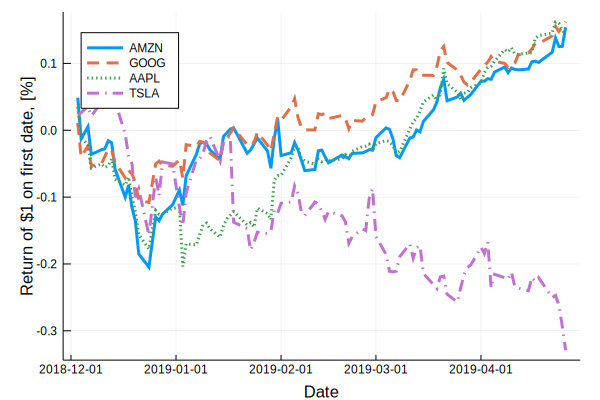

In [124]:
plt = Plots.plot(legend = :topleft, 
    xlabel = "Date", ylabel = "Return of \$1 on first date, [%]")
for (s, style) in zip(stocks, [:solid, :dash, :dot, :dashdot])
    
    Plots.plot!(stock_closes[:date][2:end], 
        cumprod(1 .+ stock_returns[Symbol(s * "_pct_change")]) .- 1,
        line = (3, style),
        label = s
    )
end
plt

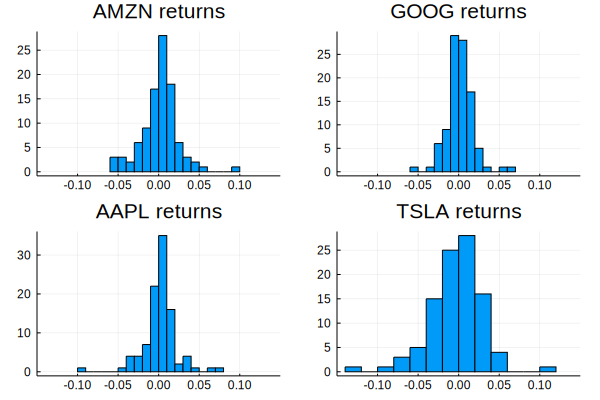

In [125]:
plts = []
x = range(-0.15, stop = 0.15, length = 100)

for s in stocks
    push!(plts, histogram(stock_returns[Symbol(s * "_pct_change")], 
            bins = 20, xlims = (-0.15, 0.15),
            title = s * " returns", label = ""))
end

Plots.plot(plts..., layout = (2, 2), size = [600, 400])

In [126]:
_prior_mu, _prior_std = [zip(values(export_prior_params)...)...]

2-element Array{NTuple{4,Float64},1}:
 (0.03, -0.03, 0.05, -0.02)
 (0.02, 0.04, 0.03, 0.01)  

In [127]:
prior_mu = [_prior_mu...]
prior_std = [_prior_std...]

4-element Array{Float64,1}:
 0.02
 0.04
 0.03
 0.01

In [128]:
model = Model(
    obs = Stochastic(2,
        (n_obs, mu, inv_cov_mat) -> 
        MultivariateDistribution[MvNormal(mu, inv_cov_mat) for _ in 1:n_obs],
    false),
    
    mu = Stochastic(1,
        prior_mu -> MvNormal(prior_mu, 1)
    ),
    
    inv_cov_mat = Stochastic(2,
        (n_obs, prior_std) -> Wishart(n_obs, LinearAlgebra.Diagonal(prior_std .^ 2))
    )

)

Object of type "Model"
-------------------------------------------------------------------------------
mu:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0×0 ArrayStochastic{2}"
Array{Float64}(0,0)
-------------------------------------------------------------------------------
inv_cov_mat:
A monitored node of type "0×0 ArrayStochastic{2}"
Array{Float64}(0,0)


In [129]:
data = Dict{Symbol, Any}(
    :obs => convert(Matrix, stock_returns),
    :prior_mu => prior_mu,
    :prior_std => prior_std,
    :n_obs => size(stock_returns, 1)
)

Dict{Symbol,Any} with 4 entries:
  :prior_std => [0.02, 0.04, 0.03, 0.01]
  :obs       => [0.0486282 0.0109646 0.0349423 0.0228544; -0.0586563 -0.0502607…
  :n_obs     => 99
  :prior_mu  => [0.03, -0.03, 0.05, -0.02]

In [130]:
inits = [
    Dict(
        :obs => data[:obs],
        :mu => prior_mu,
        :inv_cov_mat => Matrix{Float64}(I, 4, 4)
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Array{Float64,N} where N},1}:
 Dict(:mu=>[0.03, -0.03, 0.05, -0.02],:obs=>[0.0486282 0.0109646 0.0349423 0.0228544; -0.0586563 -0.0502607 -0.0439887 0.00337527; … ; 0.000262916 0.00593153 -0.00907511 -0.0426429; 0.025433 0.00690965 -0.00477397 -0.0504382],:inv_cov_mat=>[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0])
 Dict(:mu=>[0.03, -0.03, 0.05, -0.02],:obs=>[0.0486282 0.0109646 0.0349423 0.0228544; -0.0586563 -0.0502607 -0.0439887 0.00337527; … ; 0.000262916 0.00593153 -0.00907511 -0.0426429; 0.025433 0.00690965 -0.00477397 -0.0504382],:inv_cov_mat=>[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0])
 Dict(:mu=>[0.03, -0.03, 0.05, -0.02],:obs=>[0.0486282 0.0109646 0.0349423 0.0228544; -0.0586563 -0.0502607 -0.0439887 0.00337527; … ; 0.000262916 0.00593153 -0.00907511 -0.0426429; 0.025433 0.00690965 -0.00477397 -0.0504382],:inv_cov_mat=>[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0])

In [131]:
scheme = [AMWG([:mu], 1.0), AMWG([:inv_cov_mat], 1.0)]

2-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:mu]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
         
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:inv_cov_mat]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.

In [132]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 30000, burnin = 10000, thin = 2, chains = 3)

MCMC Simulation of 30000 Iterations x 3 Chains...

      From worker 2:	Chain 3:   0% [0:04:30 of 0:04:31 remaining]
      From worker 3:	Chain 2:   0% [0:03:55 of 0:03:56 remaining]
      From worker 4:	Chain 1:   0% [0:03:51 of 0:03:51 remaining]
      From worker 2:	Chain 3:  10% [0:02:10 of 0:02:24 remaining]
      From worker 3:	Chain 2:  10% [0:02:11 of 0:02:26 remaining]
      From worker 4:	Chain 1:  10% [0:02:11 of 0:02:26 remaining]
      From worker 2:	Chain 3:  20% [0:01:55 of 0:02:24 remaining]
      From worker 4:	Chain 1:  20% [0:01:56 of 0:02:25 remaining]
      From worker 3:	Chain 2:  20% [0:01:56 of 0:02:25 remaining]
      From worker 2:	Chain 3:  30% [0:01:41 of 0:02:24 remaining]
      From worker 3:	Chain 2:  30% [0:01:41 of 0:02:25 remaining]
      From worker 4:	Chain 1:  30% [0:01:41 of 0:02:25 remaining]
      From worker 2:	Chain 3:  40% [0:01:27 of 0:02:25 remaining]
      From worker 3:	Chain 2:  40% [0:01:27 of 0:02:26 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10002:30000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 10000

[0.0065506 0.00354494 … 0.014773 0.0025587; 0.00461219 0.0017356 … -0.00792963 0.0025587; … ; 0.00355418 0.00116495 … -0.00437979 -0.00739755; 0.00638968 0.00164473 … -0.00504023 -0.00194388]

[0.00472102 0.00154626 … -0.00538888 -0.000503233; 0.00316835 0.00156708 … -0.00538888 -0.000503233; … ; 0.00428218 0.00176859 … 0.00852253 0.00119921; 0.00570268 0.00243085 … 0.0110628 0.000855336]

[0.00471414 0.00469662 … 0.0168269 -0.0115385; 0.00623825 0.00540276 … 0.0168269 0.00672198; … ; 0.00582539 0.00384558 … -0.0128605 -0.00968889; 0.00552806 0.00357181 … -0.00774496 -0.0108955]

In [133]:
describe(sim)

Iterations = 10002:30000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 10000

Empirical Posterior Estimates:
                       Mean            SD             Naive SE             MCSE         ESS   
inv_cov_mat[1, 1]  0.00486221845 0.00142982053 8.25507265830209×10⁻⁶ 0.0000176192685 6585.4781
inv_cov_mat[1, 2]  0.00210260492 0.00147107170 8.49323644056249×10⁻⁶ 0.0000348037214 1786.5547
inv_cov_mat[1, 3]  0.00188736354 0.00136517486 7.88184072002099×10⁻⁶ 0.0000320980619 1808.9183
inv_cov_mat[1, 4]  0.00055084713 0.00062315503  3.5977872277267×10⁻⁶ 0.0000097918171 4050.0988
inv_cov_mat[2, 2]  0.00644716777 0.00340715778  1.9671234601473×10⁻⁵ 0.0000508734677 4485.4065
inv_cov_mat[2, 3]  0.00171757472 0.00200641354  1.1584033994769×10⁻⁵ 0.0000477323855 1766.9108
inv_cov_mat[2, 4]  0.00028910346 0.00076477202 4.41541328765671×10⁻⁶ 0.0000109116439 4912.2856
inv_cov_mat[3, 3]  0.00655876348 0.00250146168  1.4442195717961×10⁻⁵ 0.0000371081024 4544.1244
inv_cov_mat[3, 4]  0.0006

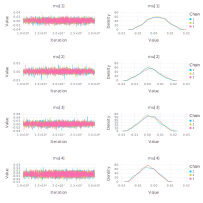

In [134]:
p = Mamba.plot(sim[:, [:mu], :], legend = true)
Mamba.draw(p, nrow = 4, ncol = 2)

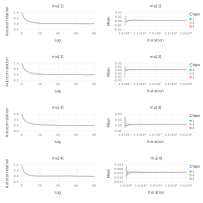

In [135]:
p = Mamba.plot(sim[:, [:mu], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 4, ncol = 2)

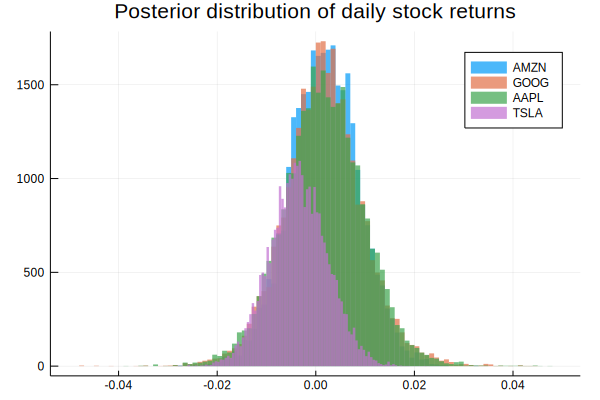

In [157]:
Plots.plot()
for (i, s) in enumerate(stocks)
    histogram!(sim[:, [:mu], :].value[:, i, :][:], 
        label = s,
        linecolor = :transparent, fillalpha = 0.7)
end
plot!(title = "Posterior distribution of daily stock returns")

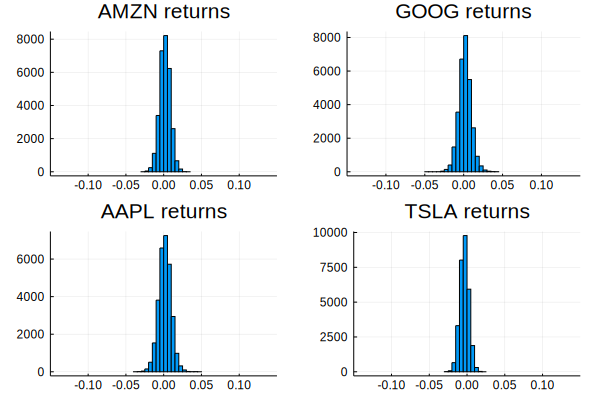

In [162]:
plts = []
x = range(-0.15, stop = 0.15, length = 100)

for (i, s) in enumerate(stocks)
    push!(plts, histogram(sim[:, [:mu], :].value[:, i, :][:], 
            bins = 20, xlims = (-0.15, 0.15),
            title = s * " returns", label = ""))
end

Plots.plot(plts..., layout = (2, 2), size = [600, 400])

In [169]:
mean(sim[:, :inv_cov_mat, :].value, dims = (1, 3))

1×10×1 Array{Float64,3}:
[:, :, 1] =
 0.00486222  0.0021026  0.00188736  …  0.00655876  0.000600963  0.00348422